In [31]:
import json
import os
import matplotlib.pyplot as plt
from google.colab import drive 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm

from sklearn.metrics import confusion_matrix
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Stage 1
- Get the json files that have the same validation and training split
- Then plot them all in one plot

In [2]:
def read_stage1_json_files(directory, splits):
    train_histories = []
    for split in splits:
        filename = f"{split}-{split}_history.json"
        if filename not in os.listdir(directory):
            continue
        filepath = os.path.join(directory, filename)
        with open(filepath, 'r') as f:
            data = json.load(f)
            train_histories.append(data)
    return train_histories

In [22]:
def train_plot(splits, histories):
  fig, axs = plt.subplots(1,2, figsize=(15, 5))
  for i, history in enumerate(histories):
      axs[0].plot(history['accuracy'], label=f"{splits[i]}")
      axs[1].plot(history['loss'], label=f"{splits[i]}")

  axs[0].set_title(f"Training Accuracy for Same Splits")
  axs[0].set_xlabel("")
  axs[0].set_ylabel("Accuracy")
  axs[0].legend()

  axs[1].set_title("Valiation Accuracy for Same Splits")
  axs[1].set_xlabel("Epoch")
  axs[1].set_ylabel("Loss")
  axs[1].legend()

  axs[0].grid(True)
  axs[1].grid(True)


  plt.tight_layout()
  plt.show()

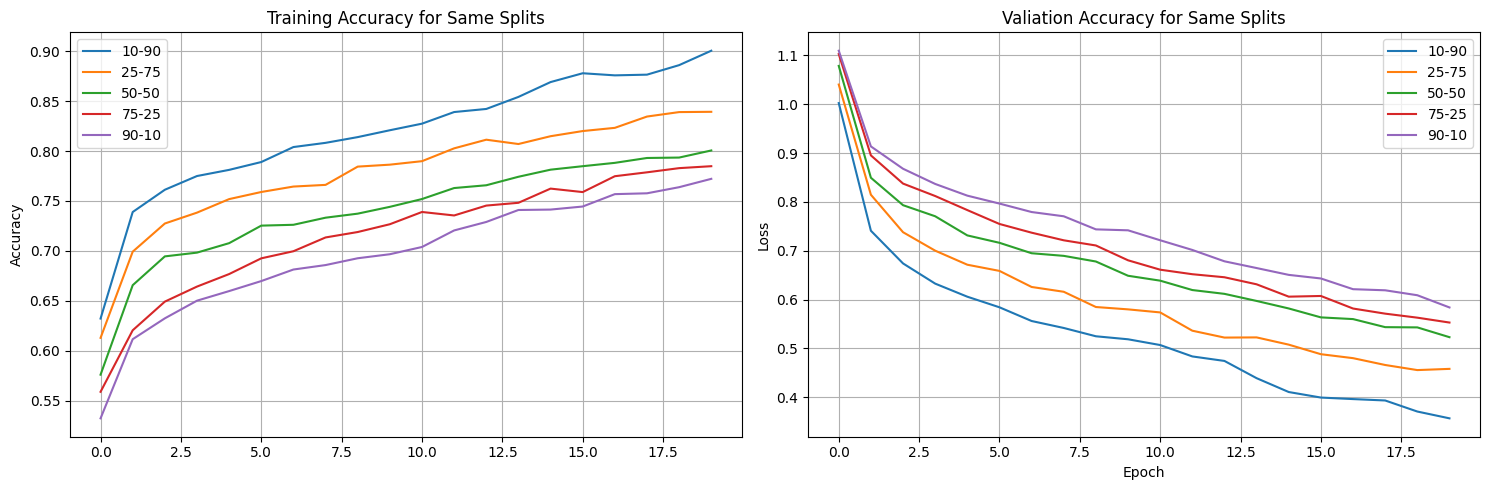

In [23]:
directory = r"/content/drive/MyDrive/model_json"
splits = ["10-90", "25-75", "50-50", "75-25", "90-10"]
train_histories = read_stage1_json_files(directory, splits)
train_plot(splits, train_histories)

# Stage 2
- For each validation split plot the validation accuracy and loss of each training run


In [28]:
# Plot the accuracy and loss for each training run against the validation set
def val_plot(val_split, train_splits, histories):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    for i, history in enumerate(histories):
        axs[0].plot(history['val_accuracy'], label=f"{train_splits[i]}")
        axs[1].plot(history['val_loss'], label=f"{train_splits[i]}")

    axs[0].set_title(f"Validation Accuracy for {val_split} split")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend()

    axs[1].set_title(f"Validation Loss for {val_split} split")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].legend()

    axs[0].grid(True)
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


In [25]:
def read_json_files_stage2(directory, val_split, train_splits):
    train_histories = []
    for train_split in train_splits:
        filename = f"{val_split}-{train_split}_history.json"
        filepath = os.path.join(directory, filename)
        with open(filepath, 'r') as f:
            data = json.load(f)
            train_histories.append(data)
    return train_histories


In [26]:
train_splits = ["10-90", "25-75", "50-50", "75-25", "90-10"]
val_splits = ["10-90", "25-75", "50-50", "75-25", "90-10"]

directory = r"/content/drive/MyDrive/model_json"


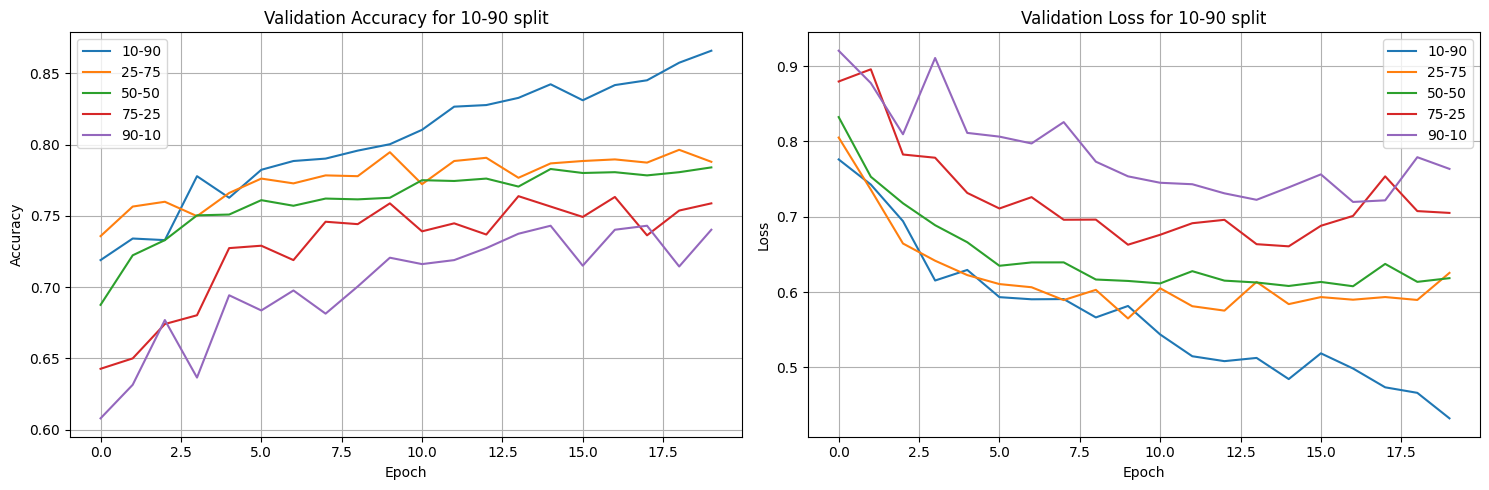

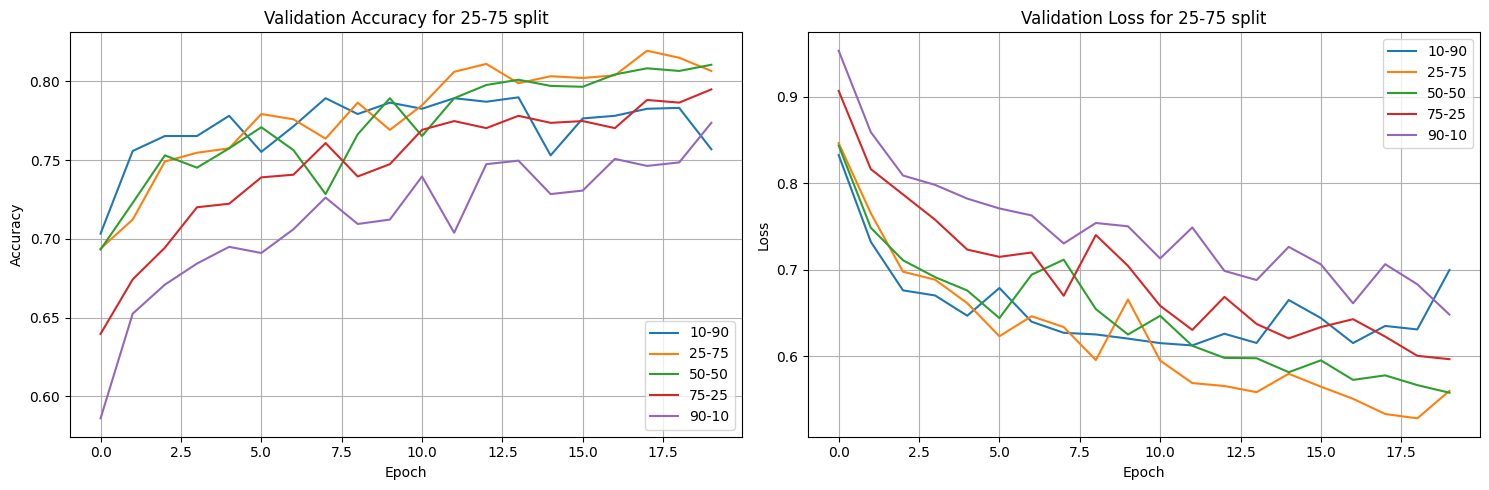

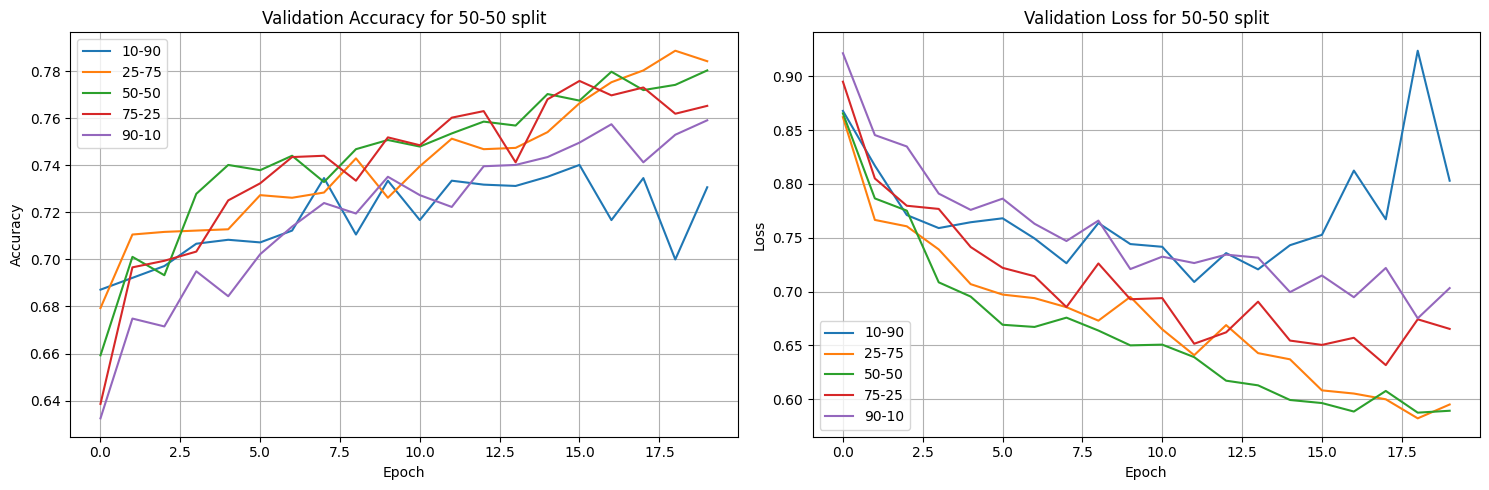

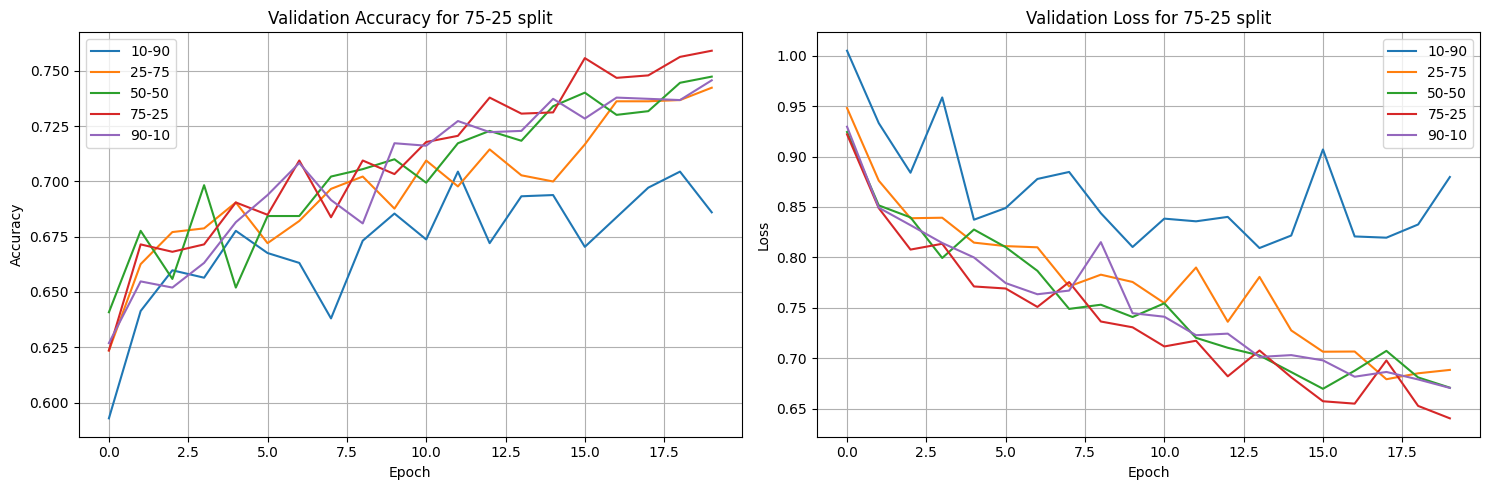

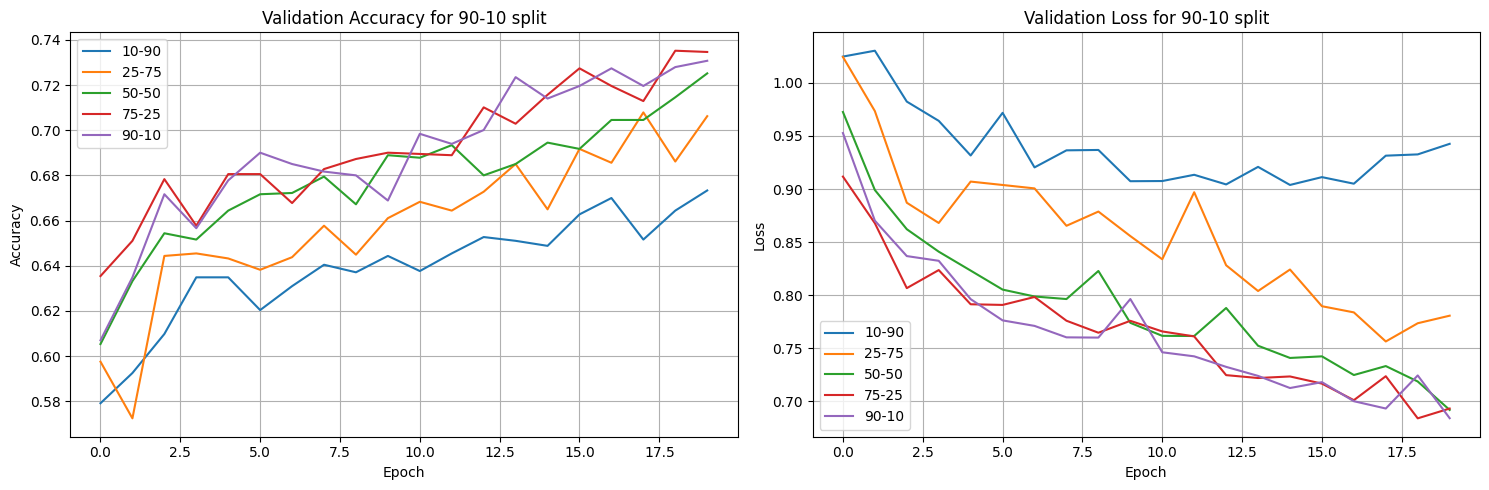

In [29]:
for val_split in val_splits:
  val_plot(val_split, train_splits, read_json_files_stage2(directory, val_split, train_splits))

# Stage 3
- Get the best validation accuracy and loss values for each run 
- Create a heatmap

In [71]:
def read_json_best(directory, val_split, train_splits):
    val_accuracies = []
    val_losses = []
    for train_split in train_splits:
        filename = f"{val_split}-{train_split}_history.json"
        filepath = os.path.join(directory, filename)
        with open(filepath, 'r') as f:
            data = json.load(f)
            val_accuracies.append(data['val_accuracy'][-1])
            val_losses.append(data['val_loss'][-1])
    return val_accuracies, val_losses

In [72]:
def json_to_frame(directory, val_splits, train_splits):
    stacked_val_accuracies = []
    stacked_val_losses = []
    for val_split in val_splits:
        val_accuracies, val_losses = read_json_best(directory, val_split, train_splits)
        stacked_val_accuracies.append(val_accuracies)
        stacked_val_losses.append(val_losses)
    
    stacked_val_accuracies = np.stack(stacked_val_accuracies, axis=1)
    stacked_val_losses = np.stack(stacked_val_losses, axis=1)
    # Create a dataframe for val_accuracies
    df_val_accuracies = pd.DataFrame(stacked_val_accuracies, index=train_splits, columns=val_splits)
    
    # Create a dataframe for val_losses
    df_val_losses = pd.DataFrame(stacked_val_losses, index=train_splits, columns=val_splits)
    
    return df_val_accuracies, df_val_losses




In [63]:
def plot_heatmaps(df_val_accuracies, df_val_losses):
    # Create the subplots
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

    # Create the heatmap for val_accuracies
    cmap1 = sns.cm.rocket_r
    heatmap1 = sns.heatmap(df_val_accuracies, cmap=cmap1, annot=True, fmt=".2f", cbar=False, ax=ax1)
    heatmap1.set_xlabel('Validation Splits')
    heatmap1.set_ylabel('Training Splits')
    heatmap1.set_title('Validation Accuracies')

    # Create the heatmap for val_losses
    cmap2 = cm.Blues_r
    heatmap2 = sns.heatmap(df_val_losses, cmap=cmap2, annot=True, fmt=".2f", cbar=False, ax=ax2)
    heatmap2.set_xlabel('Validation Splits')
    heatmap2.set_ylabel('')
    heatmap2.set_title('Validation Losses')

    # Set x-axis labels at top
    xlabels1 = heatmap1.get_xticklabels()
    heatmap1.xaxis.set_tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
    heatmap1.xaxis.set_label_position('top')
    xlabels2 = heatmap2.get_xticklabels()
    heatmap2.xaxis.set_tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
    heatmap2.xaxis.set_label_position('top')

    plt.tight_layout()
    plt.show()



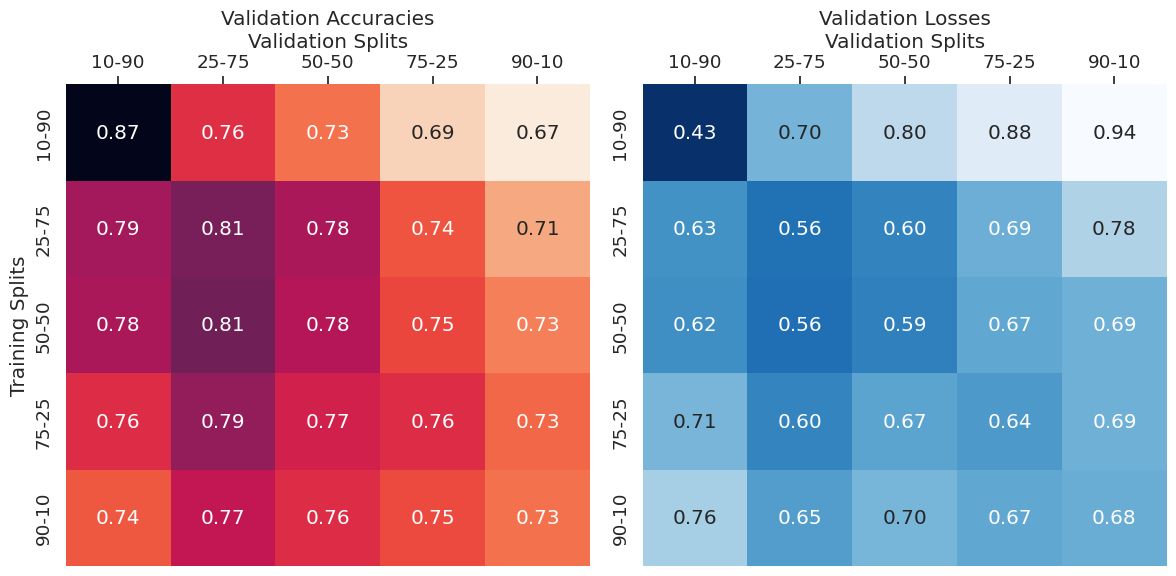

In [65]:
directory = r"/content/drive/MyDrive/model_json"
val_splits = ["10-90", "25-75", "50-50", "75-25", "90-10"]
train_splits = ["10-90", "25-75", "50-50", "75-25", "90-10"]

acc, loss = json_to_frame(directory, val_splits, train_splits)
plot_heatmaps(acc, loss)




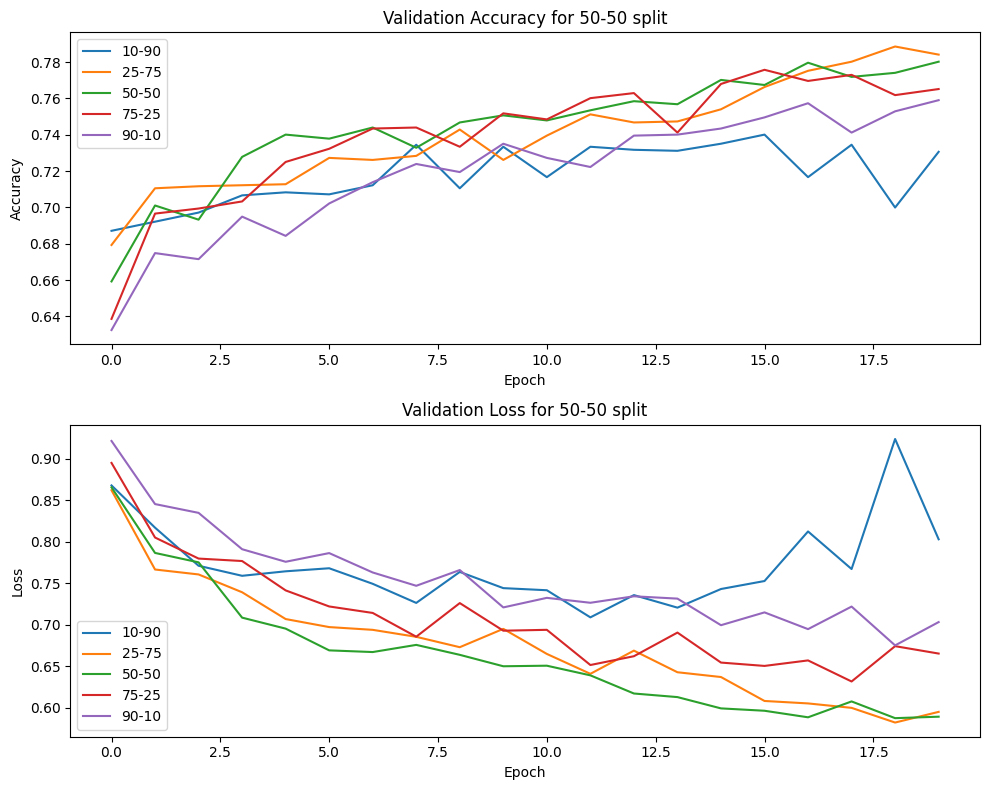

In [36]:
directory = r"/content/drive/MyDrive/model_json"
val_split = '50-50'
train_splits = ["10-90", "25-75", "50-50", "75-25", "90-10"]
train_histories = read_json_files(directory, val_split, train_splits)
val_plot(val_split, train_splits, train_histories)

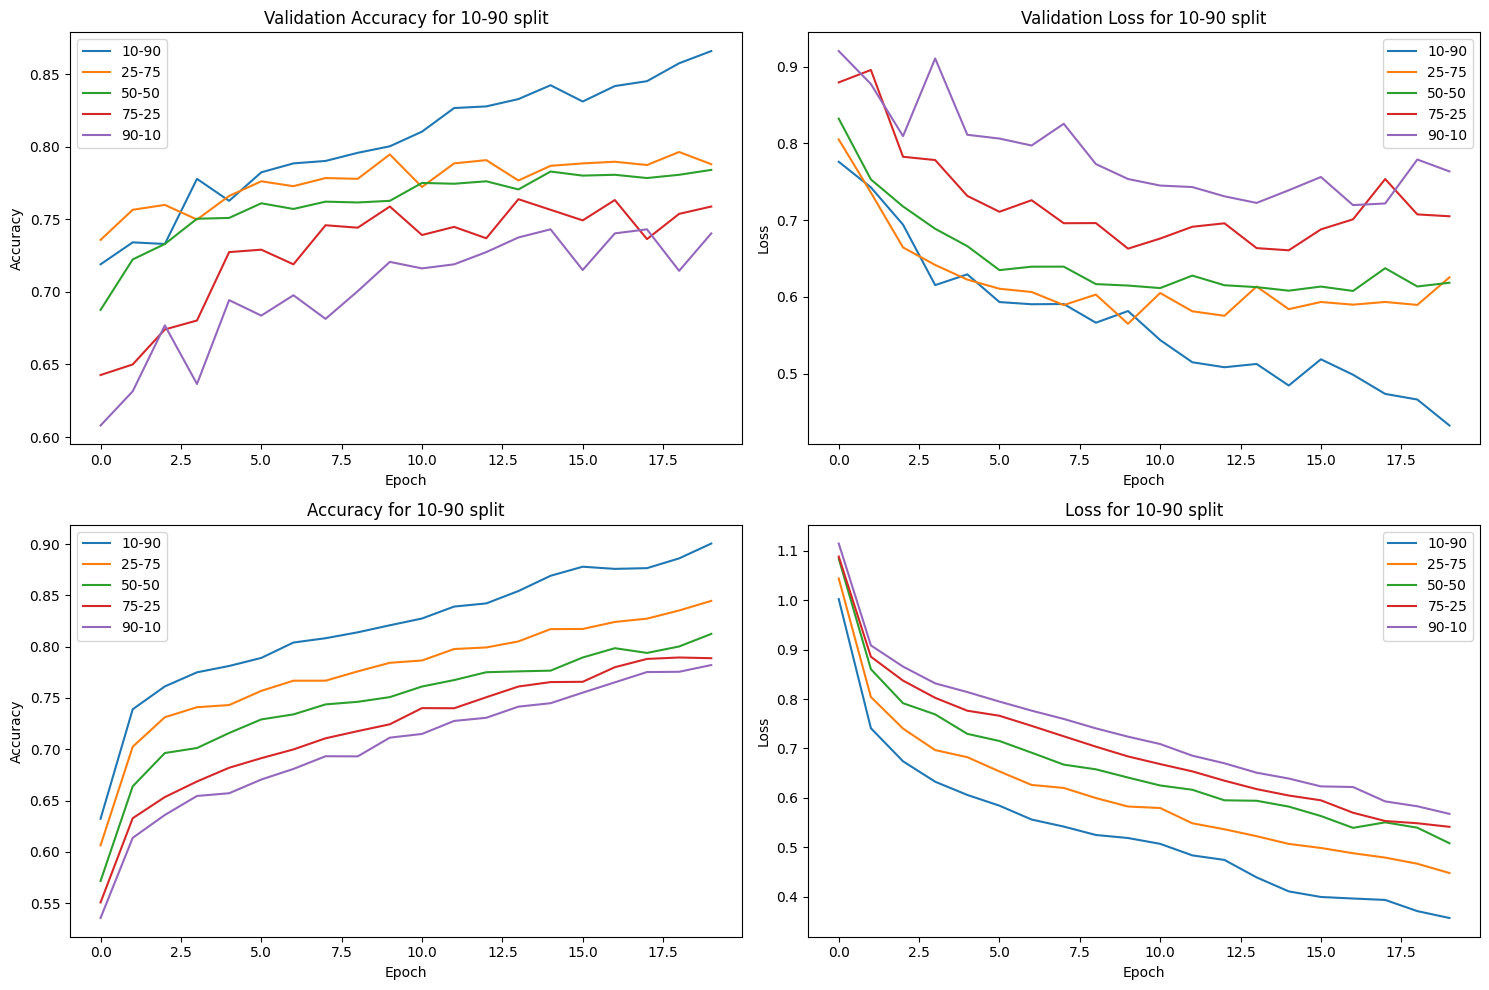

In [26]:
val_split = '10-90'
train_splits = ["10-90", "25-75", "50-50", "75-25","90-10"]
train_histories = read_json_files(directory, val_split, train_splits)
val_plot(val_split, train_splits, train_histories)

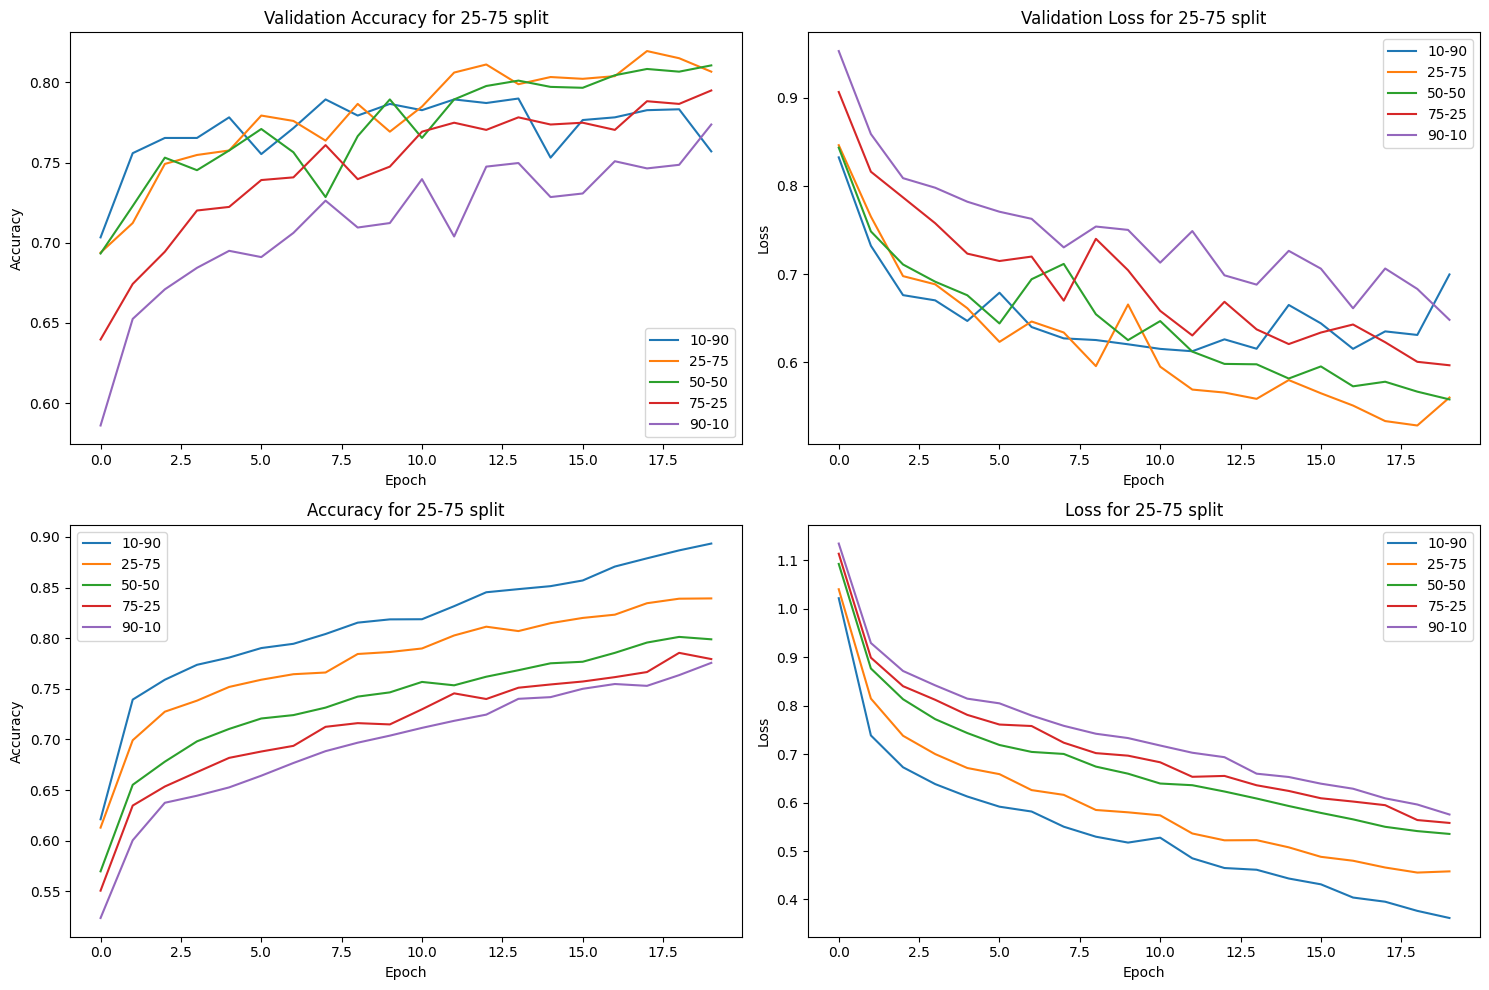

In [27]:
val_split = '25-75'
train_splits = ["10-90", "25-75", "50-50", "75-25","90-10"]
train_histories = read_json_files(directory, val_split, train_splits)
val_plot(val_split, train_splits, train_histories)

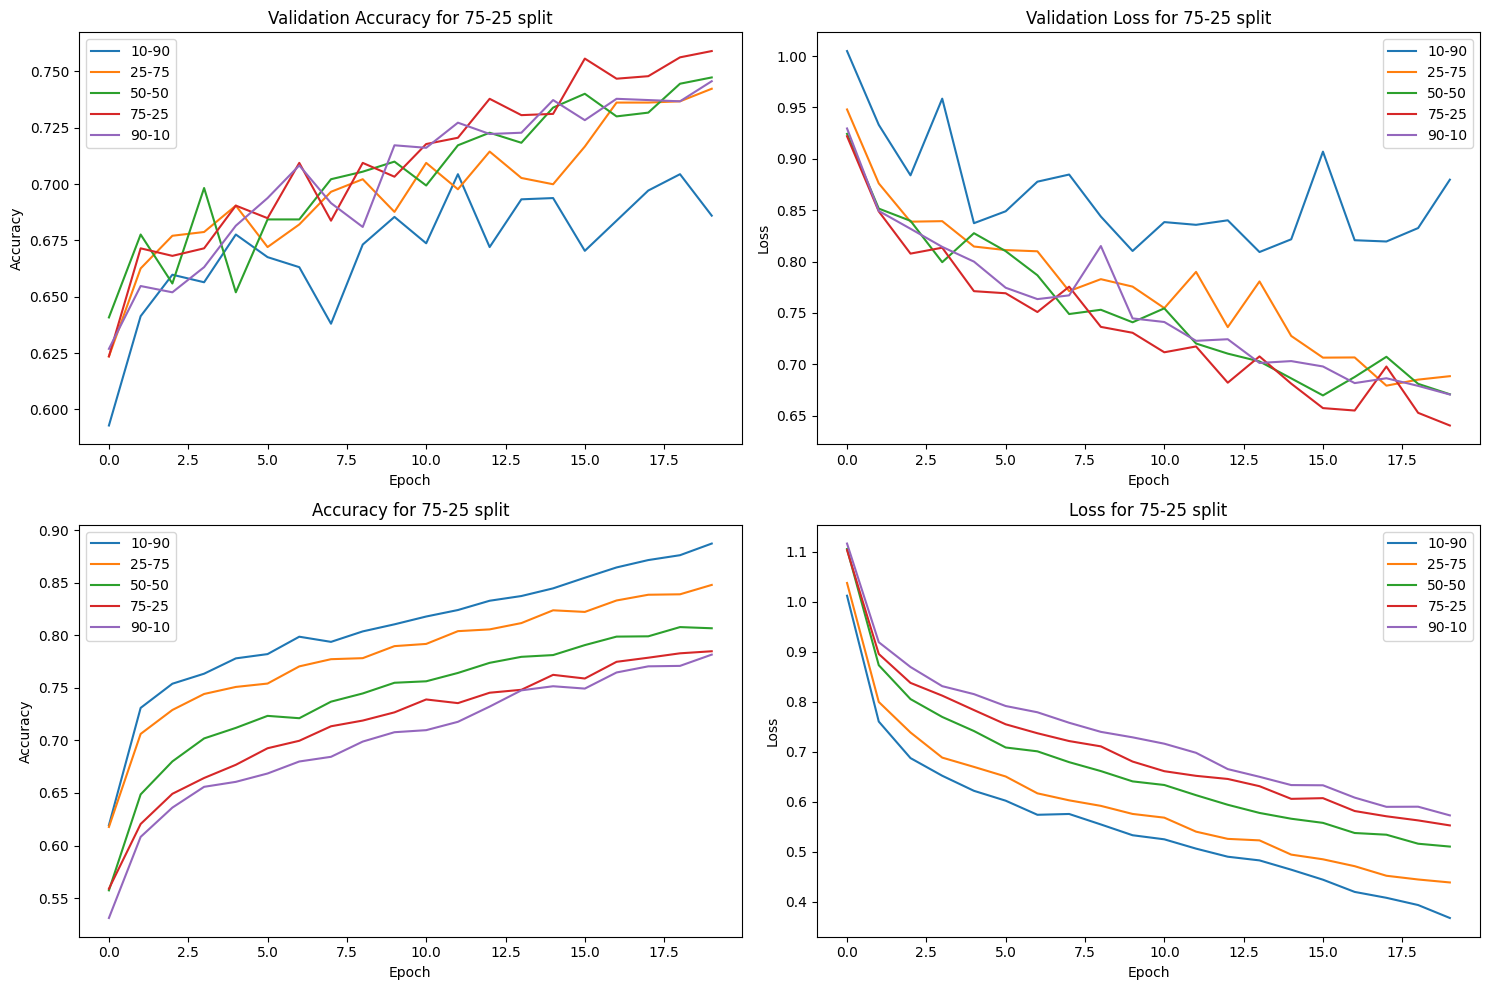

In [28]:
val_split = '75-25'
train_splits = ["10-90", "25-75", "50-50", "75-25","90-10"]
train_histories = read_json_files(directory, val_split, train_splits)
val_plot(val_split, train_splits, train_histories)

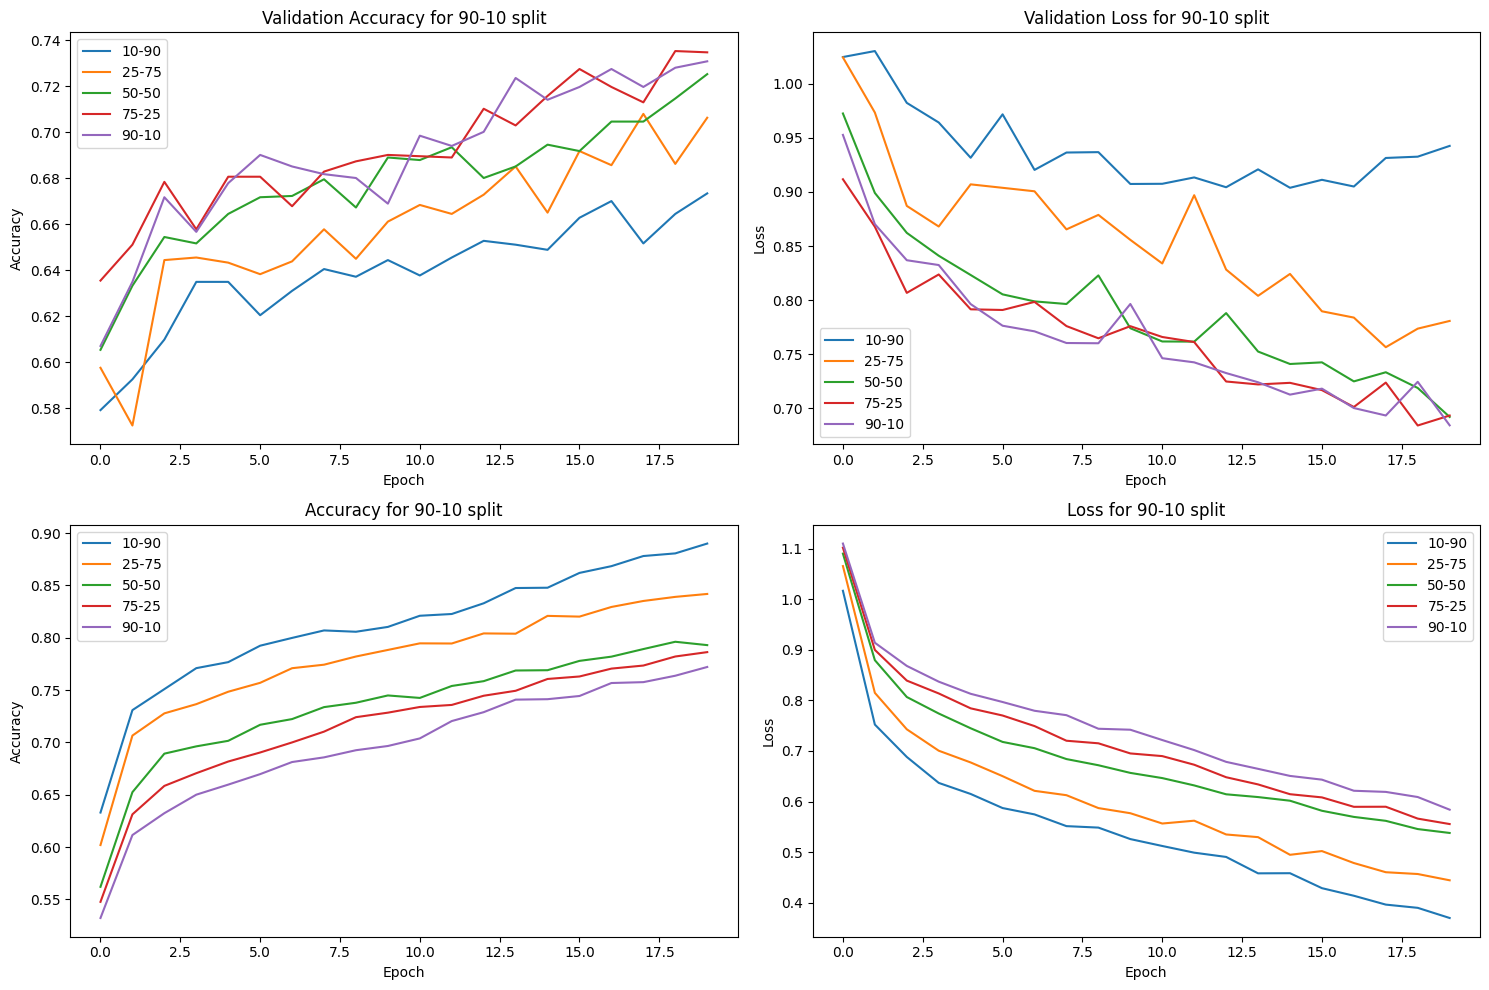

In [30]:
val_split = '90-10'
train_splits = ["10-90", "25-75", "50-50", "75-25","90-10"]
train_histories = read_json_files(directory, val_split, train_splits)
val_plot(val_split, train_splits, train_histories)